In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import astropy.units as u
from rms import Planet, Star, Spot, STSP

In [44]:
d = Planet(per=4.049959*u.day, inc=90*u.deg, a=39.68, t0=0, 
           rp=(0.3566/100)**0.5, lam=0, ecc=0, w=90)

times = Time(np.arange(-0.025, 0.025, 1/60/60/24), format='jd')

star = Star(planet=d, rotation_period=3.3*u.day, inc_stellar=90, spot_contrast=0.7, 
            rho_s=51.1)

tiny_spot = [Spot(89*u.deg, 0*u.deg, 0.00001)]

with STSP(times, star, tiny_spot, quiet=True) as stsp:
    spotless_lc = stsp.generate_lightcurve(n_ld_rings=1000)

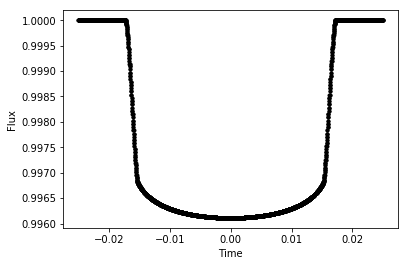

In [45]:
spotless_lc.plot()

In [46]:
r = 0.05
dlong = 8

lat1 = 30*u.deg
lat2 = -30*u.deg

spots = [Spot(lat1, i*u.deg, r) for i in range(0, 360, dlong)]
spots.extend([Spot(lat1+dlong/1.5*u.deg, (i+dlong/2)*u.deg, r) for i in range(0, 360, dlong)])
spots.extend([Spot(lat1-dlong/1.5*u.deg, (i+dlong/2)*u.deg, r) for i in range(0, 360, dlong)])

spots.extend([Spot(lat2, i*u.deg, r) for i in range(0, 360, dlong)])
spots.extend([Spot(lat2+dlong/1.5*u.deg, (i+dlong/2)*u.deg, r) for i in range(0, 360, dlong)])
spots.extend([Spot(lat2-dlong/1.5*u.deg, (i+dlong/2)*u.deg, r) for i in range(0, 360, dlong)])

In [47]:
from matplotlib.patches import Polygon

def add_circle_patch(ax, radius, lat1, lon1, n_points=20, **kwargs):
    """
    add patch with circle of radius [rad] with lat/lon [radians]
    
    kwargs passed to matplotlib.patches.Polygon.
    
    Conversion formula discovered here: 
    http://williams.best.vwh.net/avform.htm#LL
    """
    d = radius
    thetas = np.linspace(0, -2*np.pi, n_points)[:, np.newaxis]

    lat = np.arcsin(np.sin(lat1) * np.cos(d) + np.cos(lat1) *
                    np.sin(d) * np.cos(thetas))
    dlon = np.arctan2(np.sin(thetas) * np.sin(d) * np.cos(lat1), 
                      np.cos(d) - np.sin(lat1) * np.sin(lat))

    lon = ((lon1 - dlon + np.pi) % (2*np.pi)) - np.pi
    xy = np.hstack([lon, lat])
    
    if (xy[:, 0].min() > np.radians(-170)) and (xy[:, 0].max() < np.radians(170)):
        # If circle isn't split between E/W-ern hemispheres: 
        polygon = Polygon(xy, True, rasterized=True, **kwargs)
        ax.add_patch(polygon)
    else:        
        # If circle is split between E/W-ern hemispheres,
        # plot western hemisphere first
        xy_1 = xy.copy()
        xy_1[:, 0][xy_1[:, 0] > 0] -= 2 * np.pi
        polygon_1 = Polygon(xy_1, True, rasterized=True, **kwargs)
        ax.add_patch(polygon_1)

        # then plot eastern hemisphere
        xy_2 = xy.copy()
        xy_2[:, 0][xy_2[:, 0] < 0] += 2 * np.pi
        polygon_2 = Polygon(xy_2, True, rasterized=True, **kwargs)
        ax.add_patch(polygon_2)
        
def custom_grid(ax, color='gray'):
    # plot latitude/longitude grid
    ax.xaxis.set_major_locator(plt.FixedLocator(np.pi / 3 * np.linspace(-2, 2, 5)))
    ax.xaxis.set_minor_locator(plt.FixedLocator(np.pi / 6 * np.linspace(-5, 5, 11)))
    ax.yaxis.set_major_locator(plt.FixedLocator(np.pi / 12 * np.linspace(-5, 5, 11)))
    ax.yaxis.set_minor_locator(plt.FixedLocator(np.pi / 12 * np.linspace(-5, 5, 11)))

    ax.grid(True, which='minor', color=color, ls=':')
    
    if color != 'gray':
        for l in ax.get_xticklabels():
            l.set_color(color)

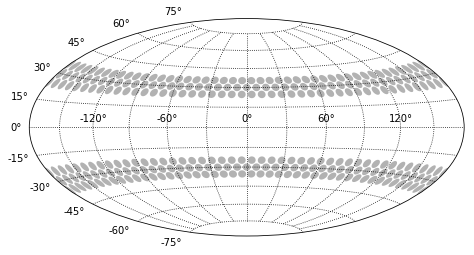

In [48]:
projection = 'Hammer'

cmap = plt.cm.Greys # plt.cm.copper
fraction_of_colorbar = 0.7
circle_color = 'k'

# Plot the built-in projections
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot(111, projection=projection.lower())

# plot spots
for spot in spots: 
    add_circle_patch(ax, np.arctan(spot.r), np.radians(spot.latitude).value, np.radians(spot.longitude).value, 
                     facecolor='k', edgecolor='none', lw=2,
                     alpha=0.3)
custom_grid(ax, color='k')
plt.savefig('spot_map_2.pdf', dpi=200, bbox_inches='tight')

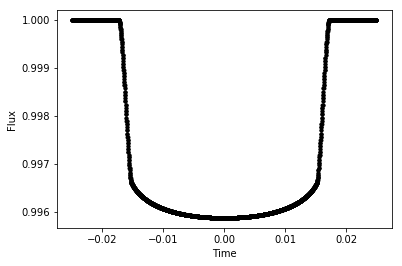

In [49]:

with STSP(times, star, spots) as stsp:
    spotted_lc = stsp.generate_lightcurve(n_ld_rings=1000)
    
spotted_lc.plot()

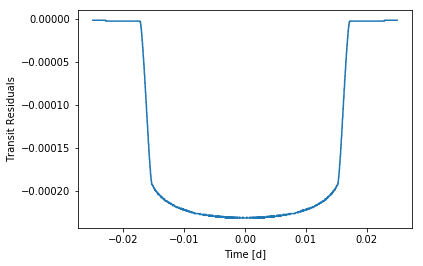

In [50]:
plt.plot(spotted_lc.times.jd, spotted_lc.fluxes - spotless_lc.fluxes)
plt.ylabel('Transit Residuals')
plt.xlabel('Time [d]')
plt.savefig('residuals_2.png', dpi=150, bbox_inches='tight')

In [51]:
np.savetxt('ring2.txt', np.vstack([spotted_lc.times.jd, spotted_lc.fluxes, spotless_lc.fluxes]).T)